#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
x_test = pd.read_csv("./Train_Test/x_test.csv")
y_test = pd.read_csv("./Train_Test/y_test.csv")

In [3]:
autoencoder_Lat_Lon = tf.keras.models.load_model('modelos_entrenamiento/entrenamiento_lat_lon2.keras')
autoencoder_Height = tf.keras.models.load_model('modelos_entrenamiento/entrenamiento_alturas2.keras')

In [4]:
# Predecimos una muestra en particular de mi df
idx = 0 
#=====Latitudes Longitudes=====
y_pred_lat_lon = autoencoder_Lat_Lon.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_true =y_test.iloc[idx]
# Separamos Latitudes Longitudes
y_true_latitudes = y_true[0:100]
y_true_longitudes = y_true[100:200]
y_pred_latitudes = y_pred_lat_lon[0,0:100]
y_pred_longitudes = y_pred_lat_lon[0,100:200]

#====== Alturas =======
y_pred_heights = autoencoder_Height.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
y_pred_heights = y_pred_heights[0,0:100]
y_true_heights = y_true[200:300]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


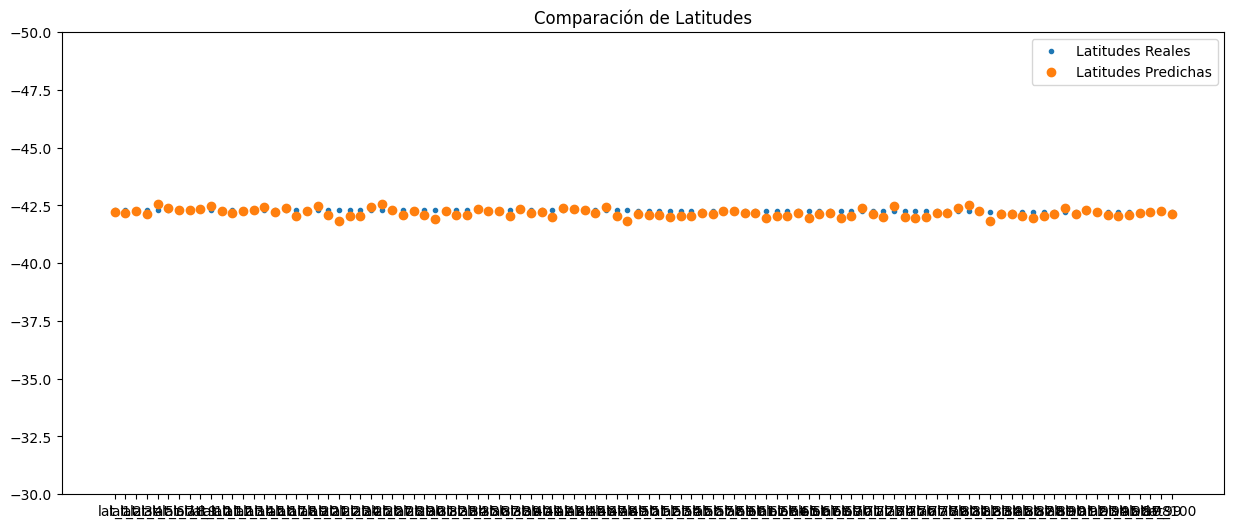

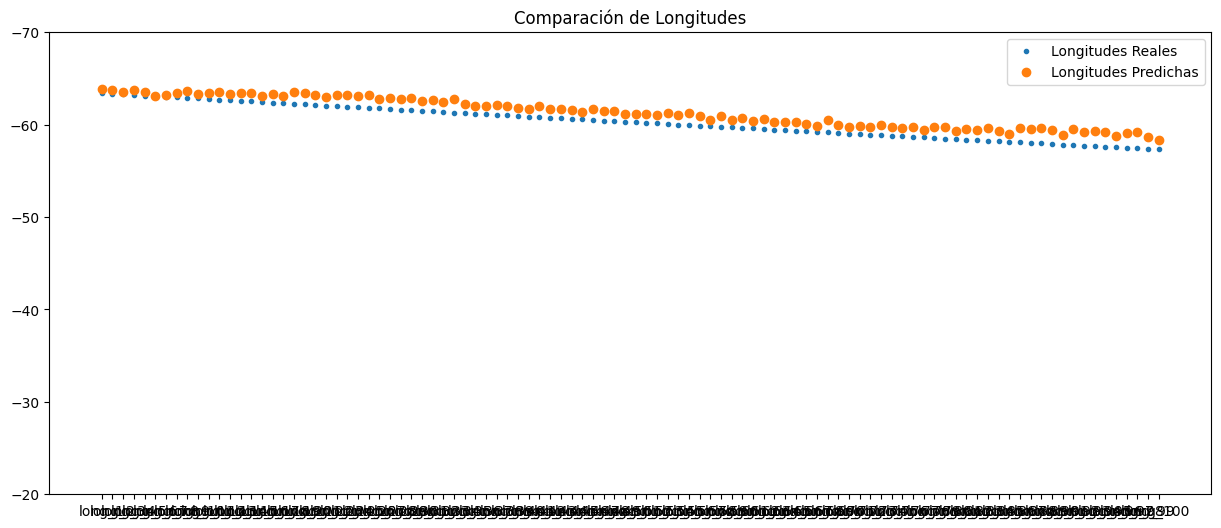

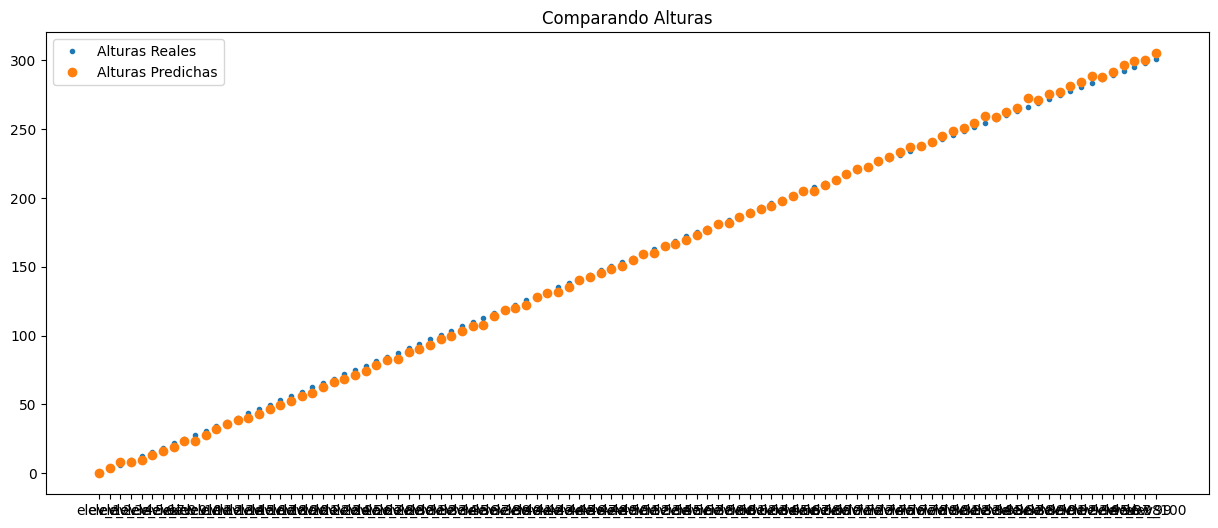

In [5]:
# Grafica Latitudes 
plt.figure(figsize = (15,6))
plt.plot(y_true_latitudes, label = 'Latitudes Reales', linestyle = 'None', marker = '.')
plt.plot(y_pred_latitudes, label = 'Latitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-30,-50)
plt.title('Comparación de Latitudes')
plt.legend()
plt.show()

# Graf. Longitudes
plt.figure(figsize=(15,6))
plt.plot(y_true_longitudes,label= 'Longitudes Reales', linestyle = 'None',marker= '.')
plt.plot(y_pred_longitudes,label= 'Longitudes Predichas', linestyle = 'None', marker = 'o')
plt.ylim(-20,-70)
plt.title("Comparación de Longitudes")
plt.legend()
plt.show()

# Graf. Alturas
plt.figure(figsize=(15,6))
plt.plot(y_true_heights, label = "Alturas Reales",linestyle= 'None', marker = '.')
plt.plot(y_pred_heights, label = "Alturas Predichas", linestyle = 'None', marker = 'o')
plt.title("Comparando Alturas")
plt.legend()
plt.show()

## Errores 
1. Error de manera individual:
  * Puedo calcular $d_{2D}$ usando **geopy.distance.geodesic**.
  * Luego calcular la diferencia de alturas $\Delta z$
  * Finalmente usar un $d_{3D} = \sqrt{(d_{2D})^2 + (\Delta z)^2}$ y así obtendría mi distancia en 3D.
2. ECM
  * Para obtener el Error Cuadrático Medio puedo, sumar los valores y dividir por la cantidad de puntos (100 puntos)
3. RECM(RMSE)
  * Por último se podría tomar la raiz del ECM para expresar el error promedio en metros.

In [6]:
#NOTA:
#   Las variables lat_true_degrees,lon_true_degrees proviene de objetos pandas.Series por lo que se tiene
#   que convertir a un array Numpy.
#   Por otro lado lat_pred_degrees,lon_pred_degrees provienen de objetos array Numpy. Por lo que 
#   no se tiene que transformar.
def Rango_Ground(lat_true_degrees,lon_true_degrees,lat_pred_degrees,lon_pred_degrees): #Determinación de Rango Terrestre
    lat_true_degrees = lat_true_degrees.to_numpy()
    lon_true_degrees = lon_true_degrees.to_numpy()
    #lat_pred_degrees = lat_pred_degrees.to_numpy()
    #lon_pred_degrees = lon_pred_degrees.to_numpy()

    lat_true = np.radians(lat_true_degrees)
    lon_true = np.radians(lon_true_degrees)
    lat_pred = np.radians(lat_pred_degrees)
    lon_pred = np.radians(lon_pred_degrees)    
    
    Re = 6371e3 # Radio de la tierra (m)
    aux = (np.sin((lat_pred-lat_true)/2))**2 + np.cos(lat_true)*np.cos(lat_pred)*(np.sin((lon_pred-lon_true)/2))**2 
    Range = 2 * Re * np.arcsin(np.sqrt(aux))
    print(Range)
    
    return Range

In [7]:
Rango = Rango_Ground(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)

[ 42001.68558929  36805.02206478  23167.25496372  49648.19769705
  43555.78131003  13101.78177338  19021.925232    40621.29452227
  63849.42810671  46224.11497636  57652.70947848  68568.68807804
  59388.8426605   65663.19955925  78353.60836569  56772.15612144
  78318.93925512  67788.13798916 104376.10254415  99793.78947296
  89251.89924658  94872.33409225  99338.60282131 106478.55904433
 104268.06218798 114195.07741985  81202.05883349 100907.30671563
  96304.05251037 114164.40494605  98396.74450774 101780.63376495
  95561.32366056 124062.33828149  77285.7070508   72318.6881266
  73323.08546755  91407.0177655   81125.75440531  71058.56754099
  64829.40363979 100257.0308711   79606.59552769  85319.53565861
  78090.08538989  65300.13916807  98499.71765821  91198.05365638
 101139.44497956  70982.09627815  74547.9675402   82941.32820329
  81710.72171783 101920.8188584   88145.1391965  104317.89946632
  92154.28461853  53926.90482357  96581.64063861  69640.84972506
  88611.58219577  71689.21

In [8]:
# Calculamos el error 
sq_rango = (Rango/1000)**2 # km
error = np.sum(sq_rango)/len(Rango)
# print(Rango/1000)
# print(sq_rango)
print("Raiz del ECM:",np.sqrt(error))


Raiz del ECM: 89.74739020182284


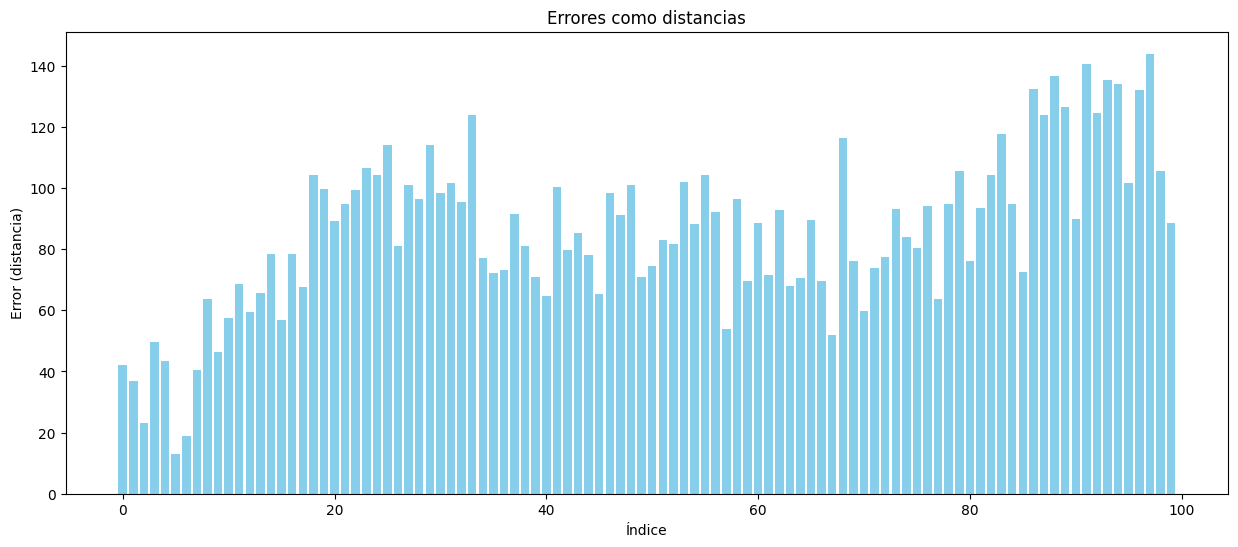

In [9]:
plt.figure(figsize=(15,6))
plt.bar(range(len(Rango/1000)), Rango/1000, color='skyblue')
plt.xlabel('Índice')
plt.ylabel('Error (distancia)')
plt.title('Errores como distancias')
plt.show()

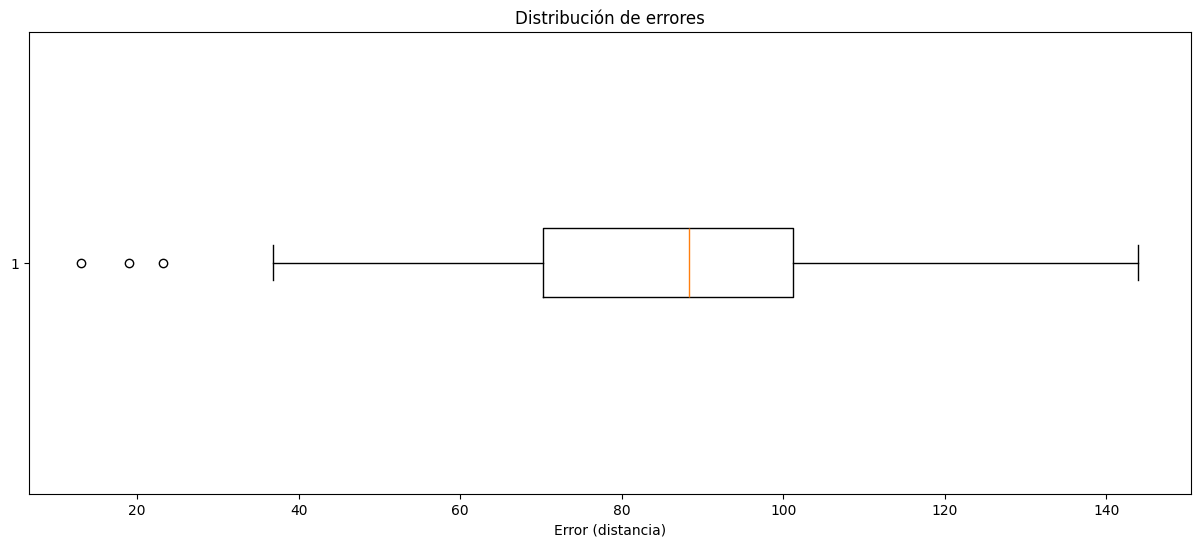

In [10]:
plt.figure(figsize=(15,6))
plt.boxplot(Rango/1000, vert=False)
plt.xlabel('Error (distancia)')
plt.title('Distribución de errores')
plt.show()

In [34]:
#Ahora vamos a corroborar usando una biblioteca
from geopy.distance import geodesic


def Distance_and_Error(lat_true,lon_true,lat_pred,lon_pred):
  lat_true = lat_true.to_numpy()
  lon_true = lon_true.to_numpy()

  errors = np.array([])

  for lat_t,lon_t,lat_p,lon_p in zip(lat_true,lon_true,lat_pred,lon_pred):
    real_coord = (lat_t,lon_t)
    predict_coord = (lat_p,lon_p)

    distance = geodesic(real_coord,predict_coord).meters
    errors = np.append(errors,distance)
  return errors


distance = Distance_and_Error(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)/1000 #Km
print("distancia 2D:",distance[99])
sq_distance = distance**2
errors_1 = np.sum(sq_distance)/len(sq_distance) #ECM
sqrt_error_1 = np.sqrt(errors_1)
print("Raiz del error ECM:",sqrt_error_1)


distancia 2D: 88.68938455416017
Raiz del error ECM: 89.96749587783464


In [ ]:
# Ahora calculamos la distancia 3D
# Las alturas true and pred estan en km RECORDAR. Ver que el input distance2D tiene que estar en la misma unidad.
# Tener en cuenta que true_heights es tipo Serie por lo que transformamos a array numpy.
def distance_3D(distance2D, true_heights, pred_heights):
  true_heights= true_heights.to_numpy() 
  dif_heights = true_heights - pred_heights

  distance_3d = np.sqrt(distance2D**2 + dif_heights**2)
  return distance_3d 


88.79881021525377


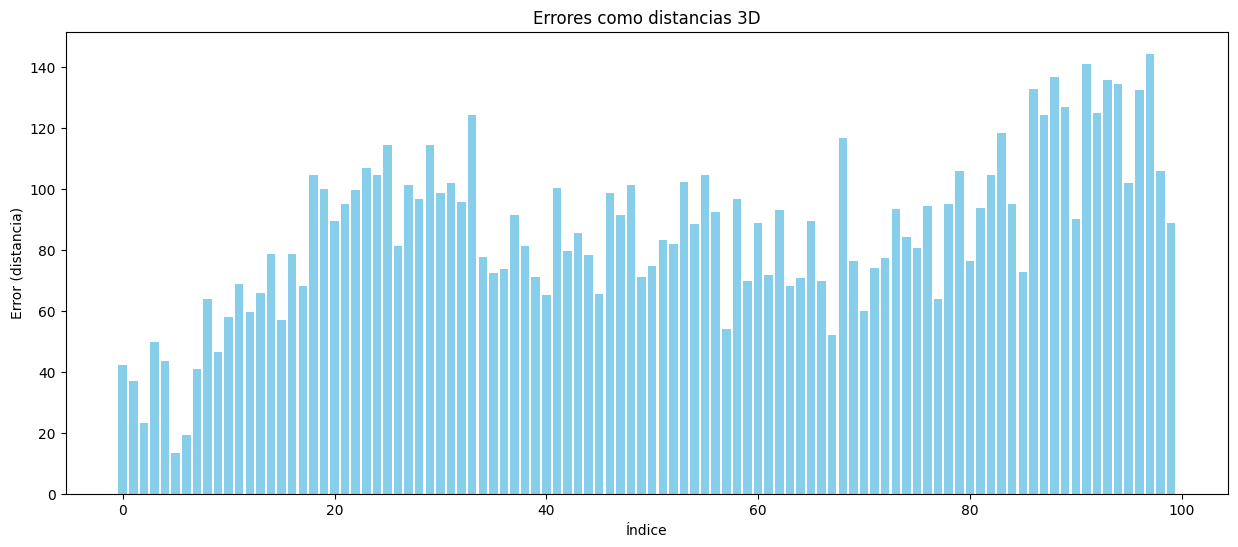

In [ ]:
# print(y_true_heights.to_numpy())
# print(y_pred_heights)

distance_3d = distance_3D(distance,y_true_heights,y_pred_heights)   

plt.figure(figsize=(15,6))
plt.bar(range(len(distance_3d)), distance_3d, color='skyblue')
plt.xlabel('Índice')
plt.ylabel('Error (distancia)')
plt.title('Errores como distancias 3D')
plt.show()

In [42]:
ECM_3d = np.sum(distance_3d**2)/len(distance_3d)
RECM_3d = np.sqrt(ECM_3d)
RECM_3d

90.00863135347352